In [51]:
import os
import torch
import pandas as pd
import numpy as np #numpy
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [52]:
image = Image.open('/Users/aditya/Downloads/data/Viral Pneumonia-1.png').convert('RGB')

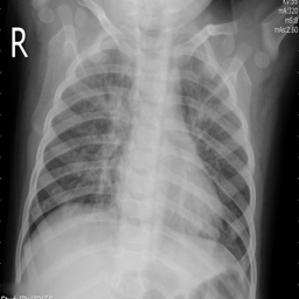

In [53]:
image

In [54]:
transformations = transforms.Compose([transforms.Resize((64, 64 )),  transforms.ToTensor()])
image = transformations(image)

In [55]:
image.shape

torch.Size([3, 64, 64])

Label: idk


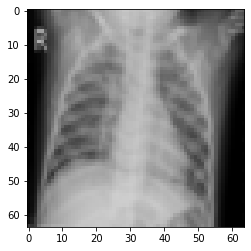

In [56]:
def show_image(img, label):
    print("Label:", label)
    plt.imshow(img.permute(1, 2, 0))
    
show_image(image, "idk")

In [57]:
 
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) #128*32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) #256*16
        self.conv4 = conv_block(256, 512, pool=True) #512*8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1024, pool=True) #1024*4
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024,1024))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)

        out = self.res3(out) + out
        out = self.classifier(out)
        return out
    
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
device


device(type='cpu')

In [58]:
model = torch.load('/Users/aditya/Desktop/Covidxray/covidxray', map_location=torch.device('cpu'))

In [31]:
in_channels=1
num_classes = 6

In [59]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    #xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    print(preds)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

tensor([3])
Label: idk , Predicted: Viral Pneumonia


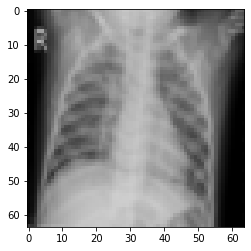

In [82]:
img = image
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', 'idk', ', Predicted:', predict_image(img, model))

In [78]:
class z():
    """Wrap a dataloader to move data to a device"""
    def __init__(self):
        self.classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [79]:
dataset=z()

In [81]:
dataset.classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']